In [1]:
import os 

import numpy as np
import scipy.stats as sps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import sys, os
sys.path += [os.path.abspath(os.pardir + '/src')]
print(sys.path)

from experiment import init_random_state, BanditLoopExperiment, get_ts_model

sns.set(font_scale=2.5, palette='tab20', font="Times New Roman") 

['/home/anton/Desktop/m1p/2021-Project-74/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/anton/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/simpleeval-0.9.10-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/sh-1.13.1-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/mldev-0.3.dev2-py3.8.egg', '/usr/lib/python3/dist-packages', '/home/anton/.local/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython', '/home/anton/Desktop/m1p/2021-Project-74/src']


In [2]:
seed = 42

p = 1.
Q = 1
w = 0.
bs = np.linspace(0., 1., 7)

T = 5000
M = 10
l = 3

In [3]:
interests, TS_paramss, responses = [], [], []

In [4]:
for b in tqdm(bs):
    init_random_state(seed)
    
    bandit = lambda: get_ts_model(M=M, l=l)
    exp = BanditLoopExperiment(bandit, "TS bandit")
    exp.prepare(w=w, Q=Q, p=p, b=b)
    exp.run_experiment(T=T)
    
    results = exp.get_as_np()
    interests.append(results.interest)
    TS_paramss.append(results.TS_params)
    responses.append(results.response)

100%|██████████| 7/7 [01:28<00:00, 12.70s/it]


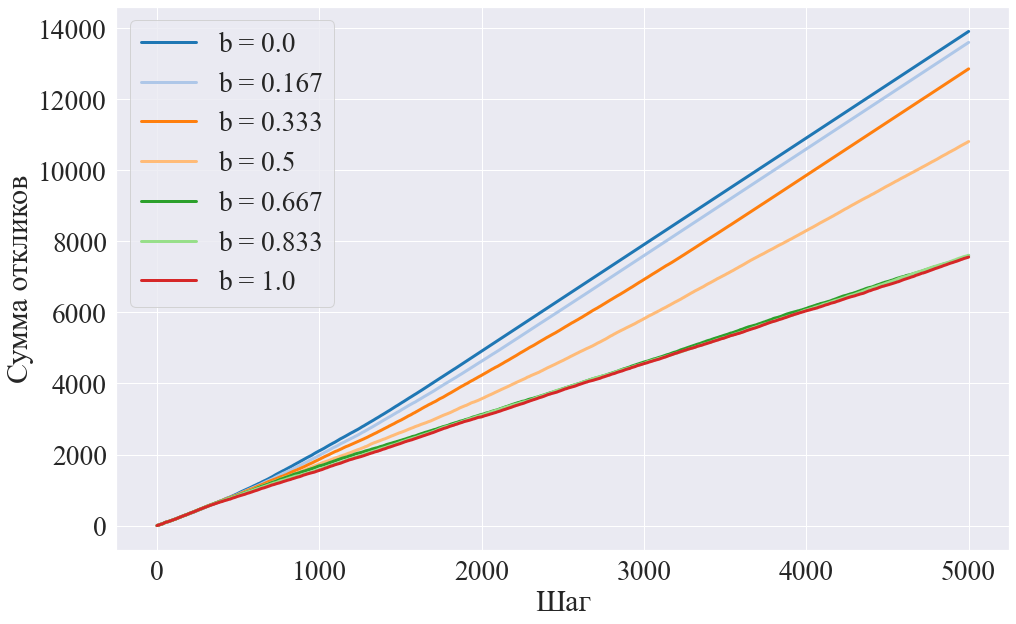

In [5]:
sum_responces = []
for  i, b in enumerate(bs):
    sum_responces.append(np.cumsum(responses[i].sum(axis=1)))
plt.figure(figsize=(16, 10))
for i, b in enumerate(bs):
    plt.plot(np.arange(1, T+1), sum_responces[i], linewidth = 3, label=f'b = {round(b,3)}')

plt.ylabel('Сумма откликов')
plt.xlabel('Шаг')
plt.legend()
# plt.savefig('rewards.pdf')

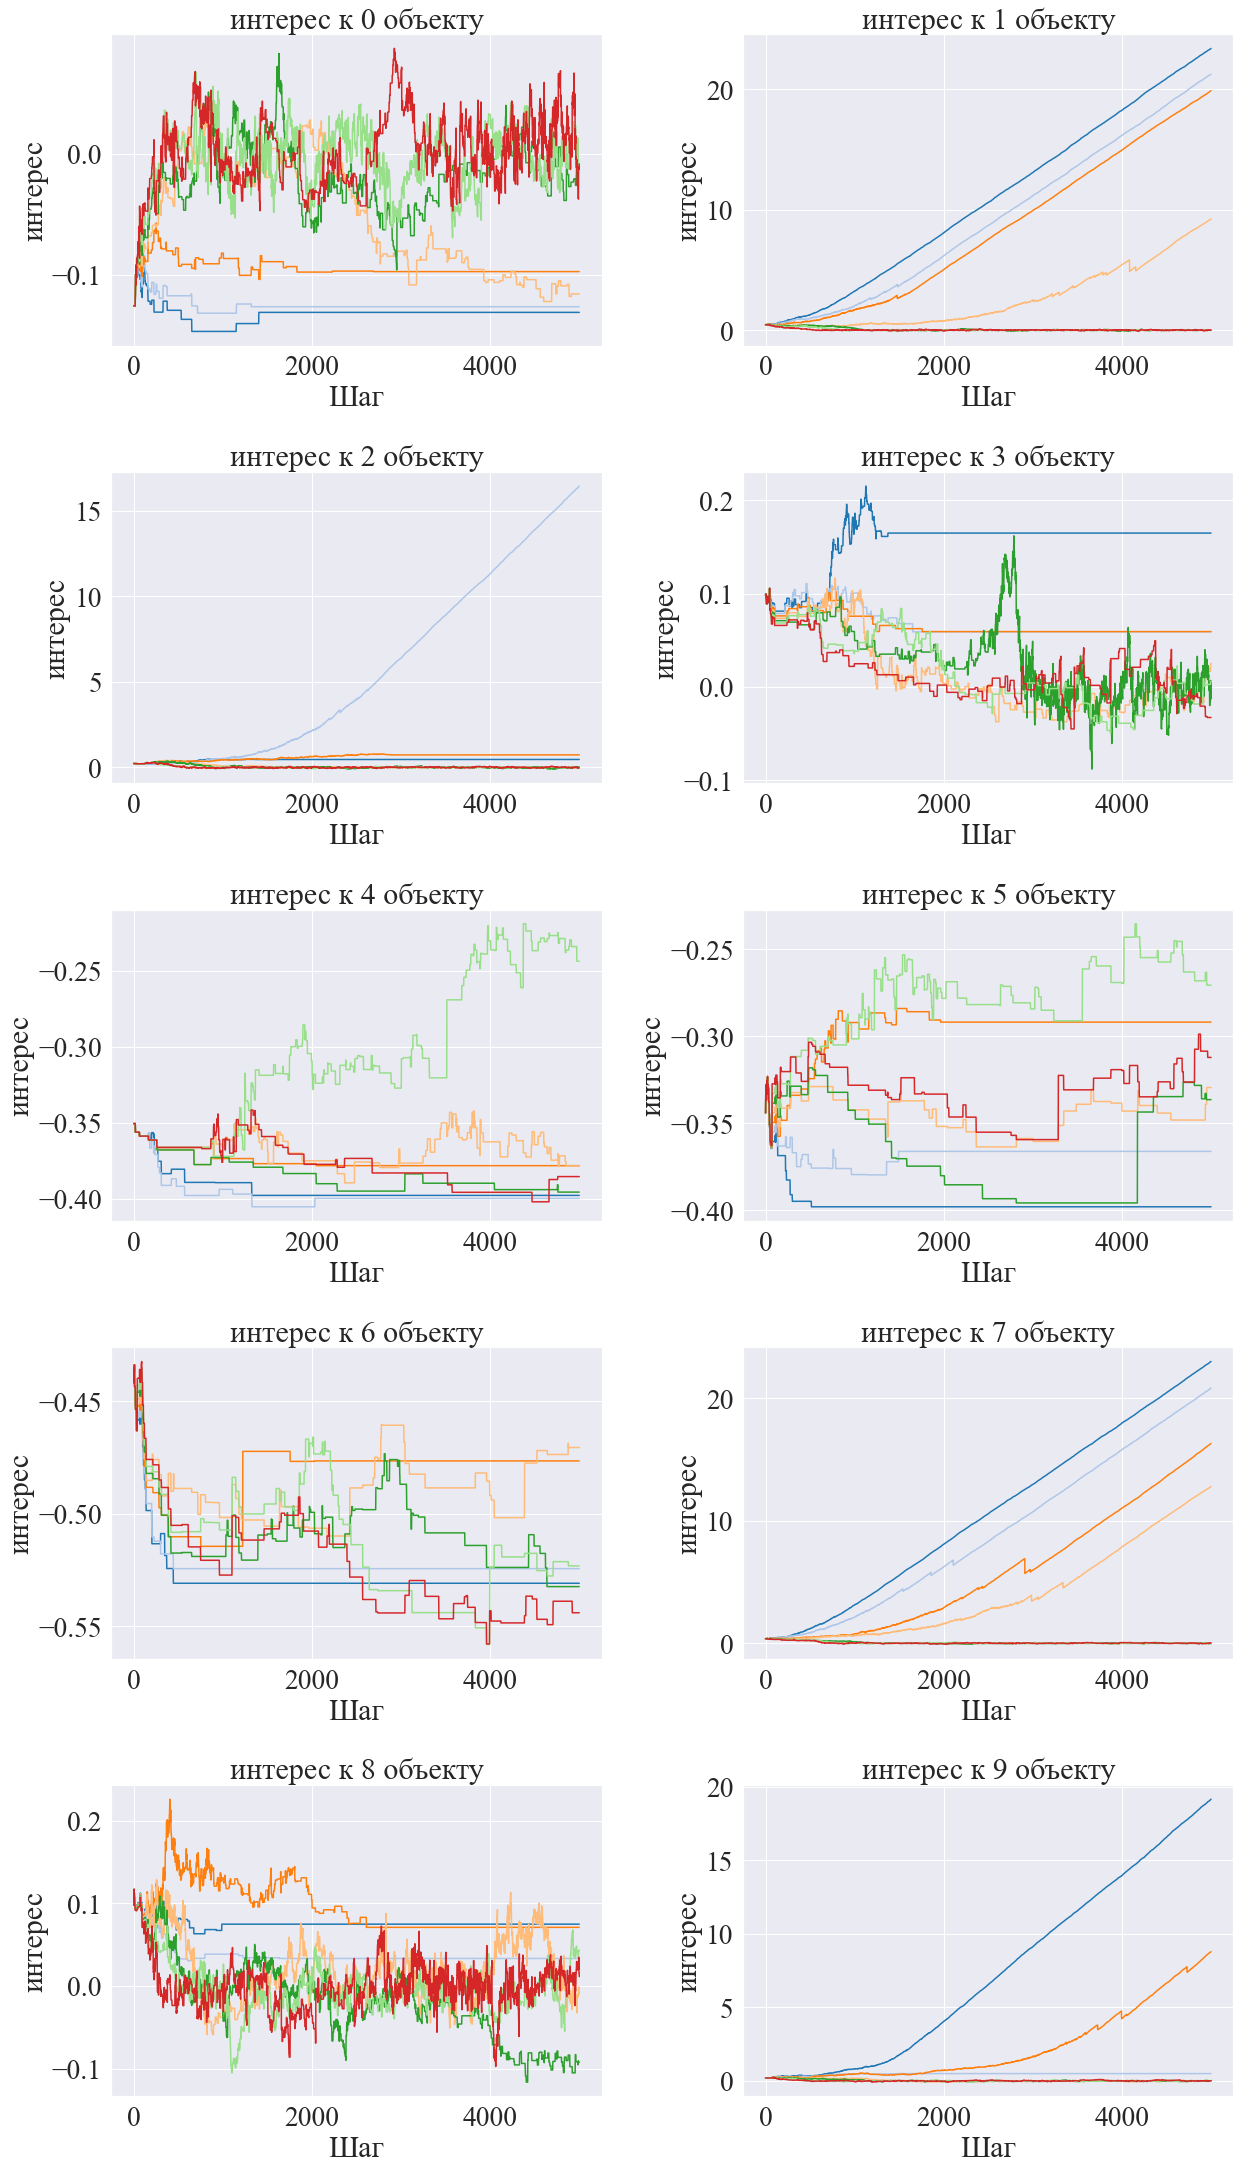

In [10]:
plt.figure(figsize=(18, 36))
for m in range(M):
    plt.subplot(M // 2 + 1, 2, m+1)
    for i, b in enumerate(bs):
        plt.plot(interests[i][:, m], label=f'b = {b}')
    plt.title(f'интерес к {m} объекту')
    plt.ylabel('интерес')
    plt.xlabel('Шаг')
#     plt.legend()

    plt.tight_layout()

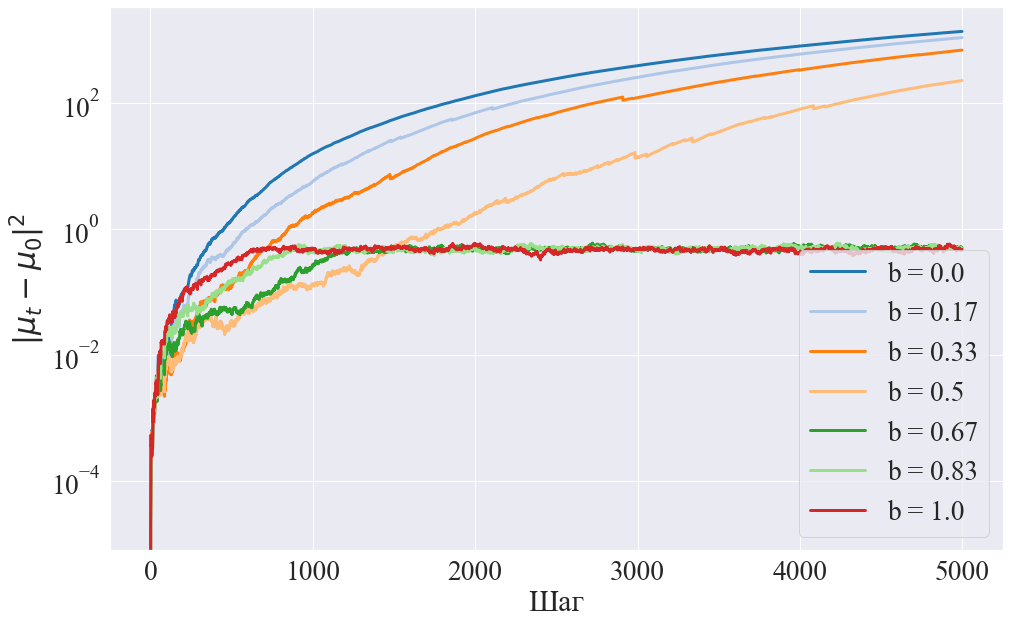

In [7]:
plt.figure(figsize=(16, 10))
for i, b in enumerate(bs):
    plt.plot(np.linalg.norm(interests[i] - interests[i][0], axis=1)**2, linewidth = 3, label=f'b = {round(b,2)}')
plt.yscale('log')
plt.ylabel(r'$\|\mu_t - \mu_0 \|^2$')
plt.legend()
plt.xlabel('Шаг')
plt.savefig('winstreak_norm_interest.pdf')

In [8]:
def draw_posteriori(grid, distr_class, post_params, obj, steps, xlim=None):
    '''Рисует серию графиков апостериорных плотностей.
    
    :param grid: сетка для построения графика
    :param distr_class: класс распределений из scipy.stats
    :param post_params: параметры апостериорных распределений 
        shape=(размер выборки, кол-во параметров)
    '''
    
    size = post_params.shape[0] - 1
    plt.figure(figsize=(12, 7))
    for n, t in enumerate(steps):
        plt.plot(grid, 
                 distr_class(post_params[n]).pdf(grid) \
                     if np.isscalar(post_params[n]) \
                     else distr_class(*post_params[n]).pdf(grid), 
                 label='t={}: {}'.format(t, np.round(post_params[n], 3)), 
                 lw=2.5,
                 color=(1-n/size, n/size, 0))
    plt.title(f'Апостериорное распределение для объекта {obj} в зависимости от шага')
    plt.grid(ls=':')
    plt.legend(fontsize=12)
    plt.xlim(xlim)
    plt.show()

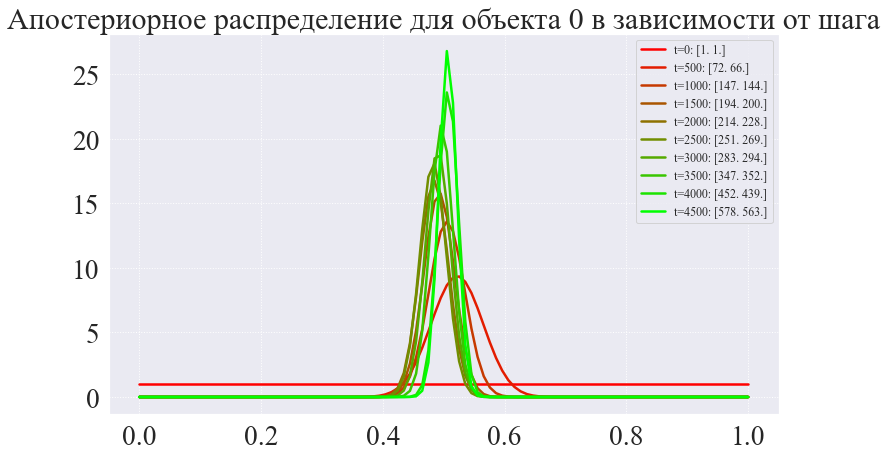

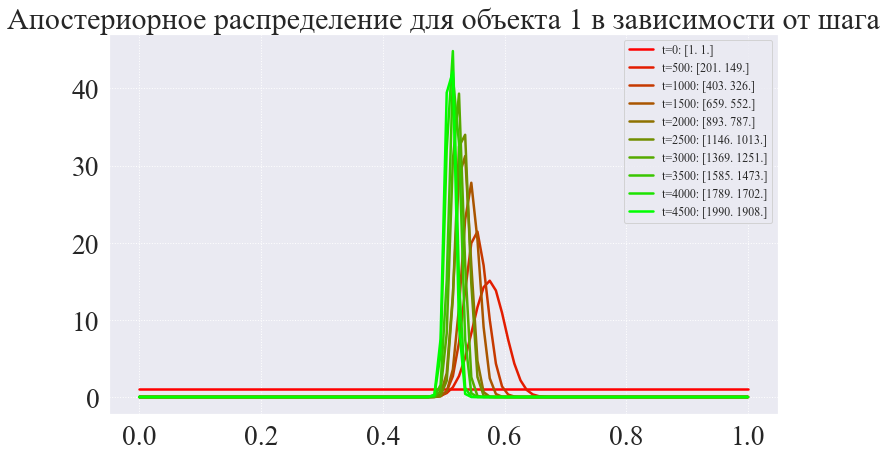

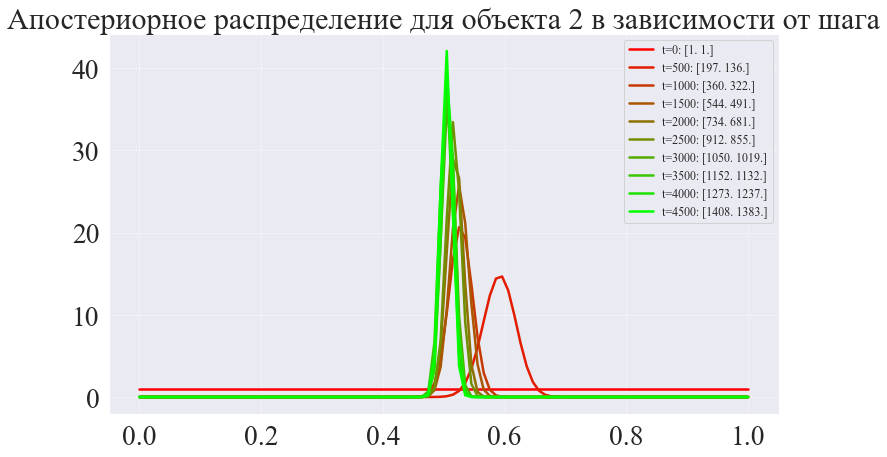

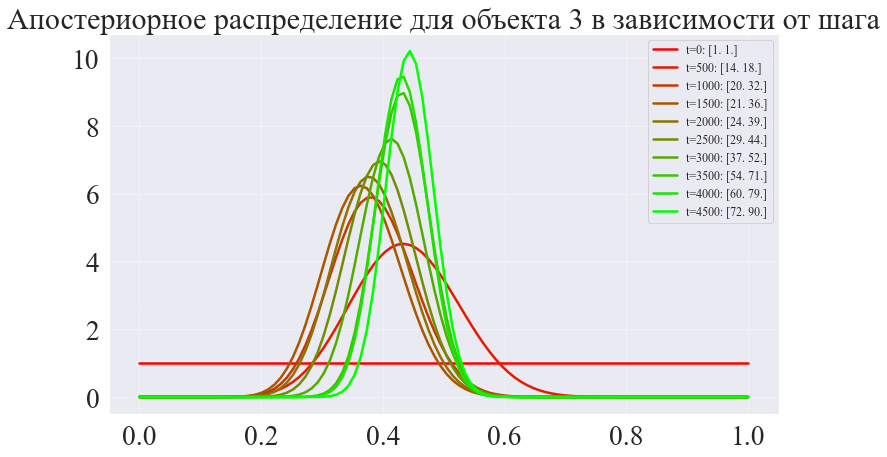

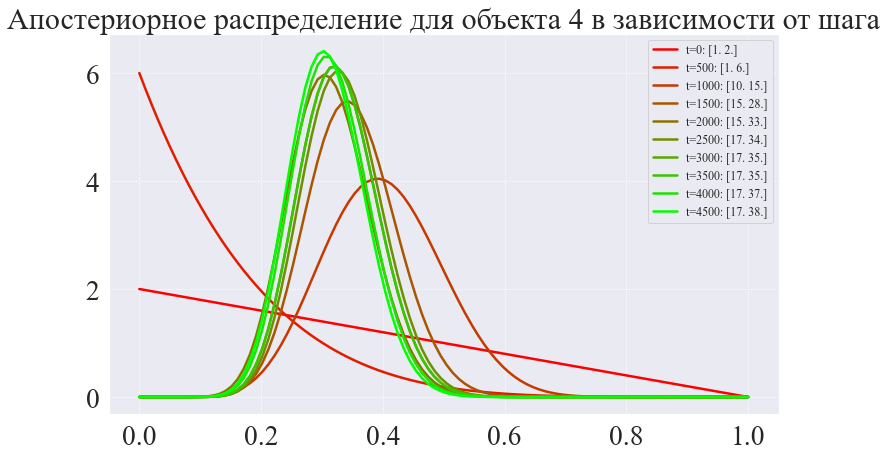

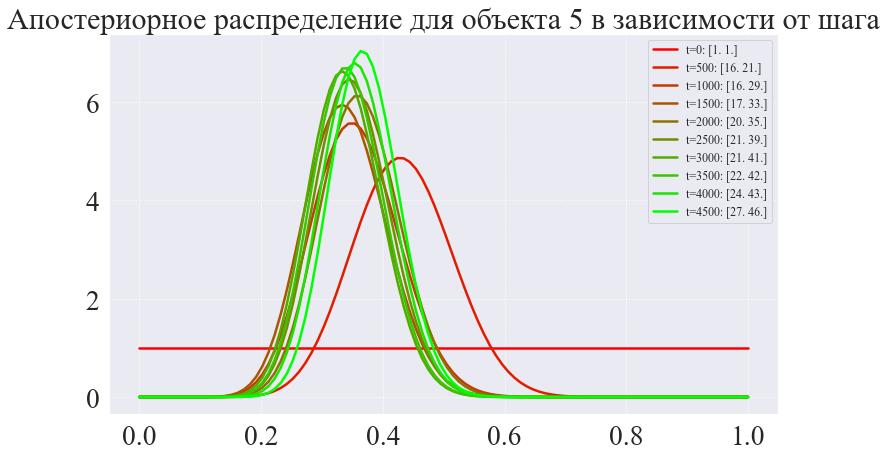

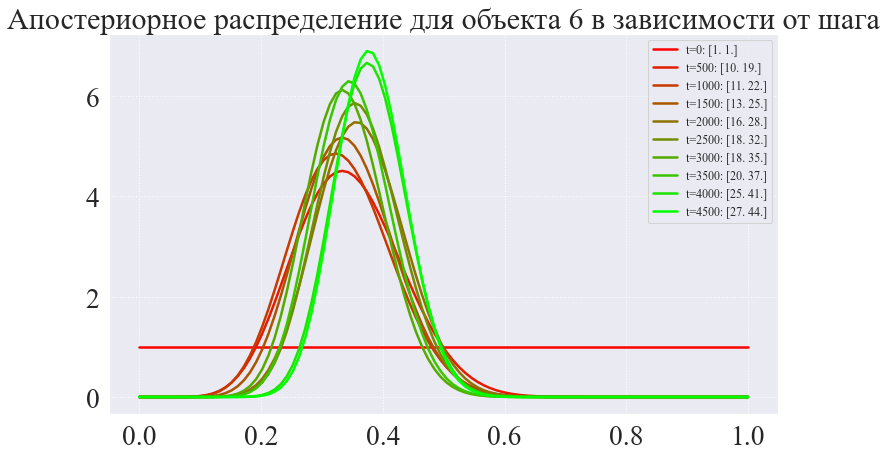

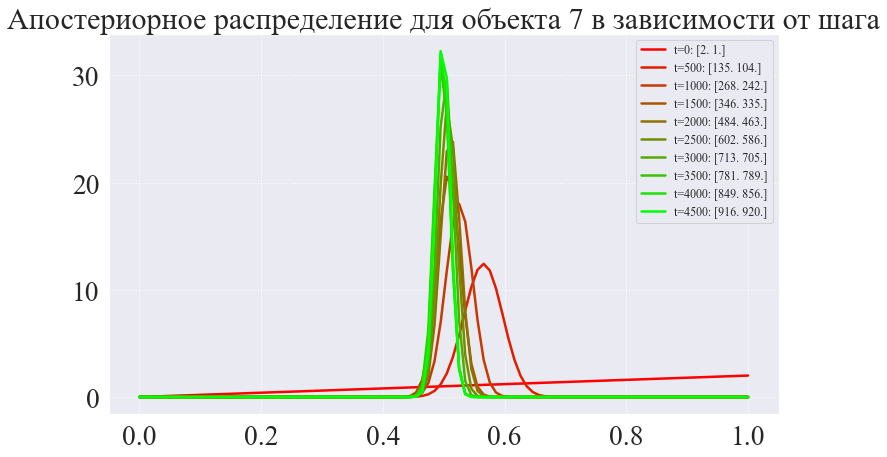

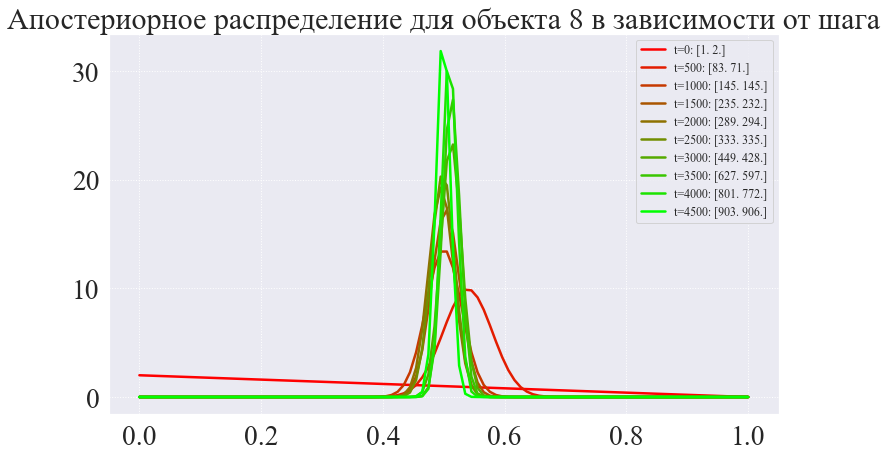

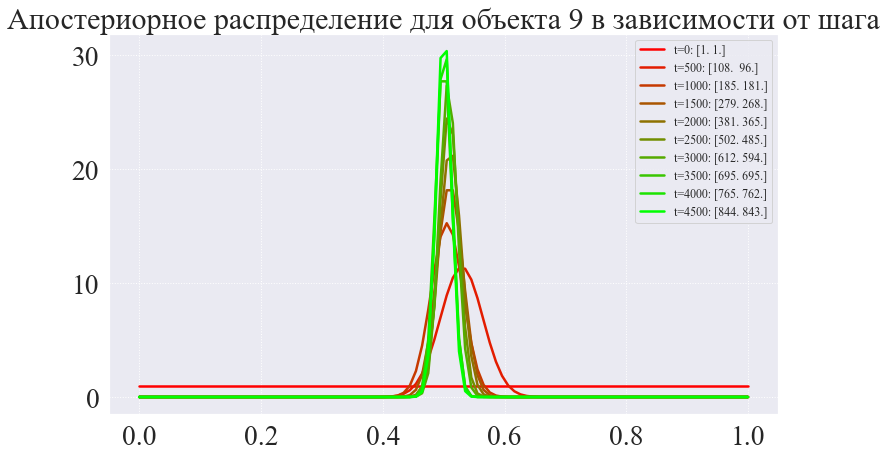

In [9]:
for i in range(M):
    draw_posteriori(np.linspace(0, 1., 100), sps.beta, TS_paramss[-1][::500][:, i], obj=i, steps = range(0, T, 500))
